# Code Review - Assignment 10
### Alexander Procton (aprocton) reviewing kuratanp

The following Python code implementing a switchpoint analysis is taken from [`nb-10.7-kuratanp.ipynb`](https://github.com/programming-for-bio/10-python-analysis2/blob/master/assignment/nb-10.7-kuratanp.ipynb).

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot

In [5]:
# fix a random seed
np.random.seed(1234)

# generate data for 167 years with higher rates before 1980 when the Oil Pollution Prevention regulation was implemented.
data = pd.DataFrame({
    "year": np.arange(1850, 2017), #Values generated between 1850~2017
    "oilspills": np.concatenate([ 
        np.random.poisson(10.0, 130), #(Lamda=# of success, size=year) average 8 oilspills per year in the first 130 years
        np.random.poisson(3.0, 37), # average 3 oilspills per year in the last 37 years
    ])
})

# introduce some random NaN values (pymc3 will handle these)
missing = np.random.randint(0, data.shape[1], 5) # sample 5 values randomly in the dataset and assign nan to make 5 missing values in the dataset 
data.loc[missing, "oilspills"] = np.nan

with pm.Model() as oilspill_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.year.min(), 
        upper=data.year.max(), 
        )

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.year, early_rate, late_rate) 
    #switch, a Theano function that works like an if statement. 
    #It uses the first argument to switch between the next two arguments.
   
    oilspills = pm.Poisson('oilspills', rate, observed=data.oilspills)

with oilspill_model:
    trace = pm.sample(100000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
Assigned Metropolis to oilspills_missing
100%|██████████| 100500/100500 [13:15<00:00, 126.35it/s]C:\Users\Alex\Miniconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.9114963136499745, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



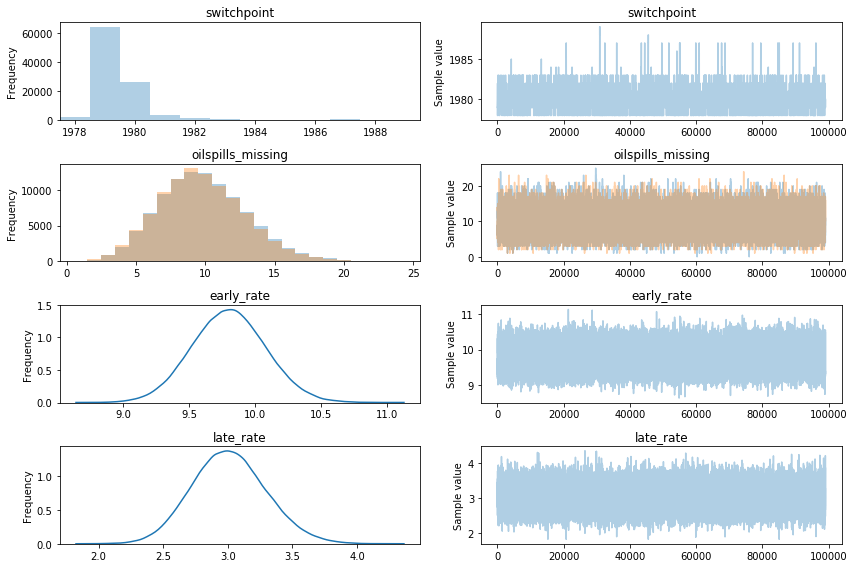

In [6]:
pm.traceplot(trace[1000:]);

In [7]:
pm.summary(trace)


switchpoint:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1979.446         0.898            0.011            [1979.000, 1981.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1979.000       1979.000       1979.000       1980.000       1982.000


oilspills_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  9.835            3.154            0.035            [3.000, 15.000]
  9.727            3.137            0.038            [3.000, 15.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  4.000          8.000          10.000         12.000         16.000
  4.000  

1. __What method did they use to generate data? What types of distributions did they sample data from? What type of data do these distributions generate?__

   The data were drawn from two Poisson distributions with different rates, to simulate the number of oil spills in years before and after Oil Pollution Protection Regulation.

2. __What type of model did they try to fit with pymc3? Did they link to the tutorial that their analysis is based on. Which parameters of the model are they trying to fit.__

   kuratanp fit a switchpoint model similar to the mine disaster model implemented in the in-class `nb-10.6`. The parameters of interest were the year of the switchpoint, the early and late rates of oil spills, and the imputed value of five missing oil spills.

3. __Are they sampling data in their model from the same type of distribution that was used to generate the data?__

   They use exponential priors for the early and late rates, appropriate for finding the rate that determined a Poisson distribution for count data. For the switchpoint, they use a uniform distribution to account for the full range of dates.

4. __Do you agree or disagree with their assessment of the model fit? Did it work well? How might you suggest improving the model, or further testing this type of model?__

   I agree with the assessment of the model; it worked well. However, running this model for 100,000 iterations on my computer took a very long time, so I suggest using fewer iterations and seeing if the results are similar.